In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
pmap2=[ "#010067","#9E008E","#FFE502","#005F39","#00FF00","#FF937E",
          "#A42400","#001544","#91D0CB","#620E00","#0000FF","#007DB5","#6A826C","#00AE7E","#C28C9F",
          "orange","#008F9C","#5FAD4E","#FF0000","#FF00F6","#FF029D","#683D3B","#FF74A3","#968AE8","#98FF52",
          "#A75740","#01FFFE","#FFEEE8","#FE8900","#BDC6FF","#01D0FF","#BB8800","#7544B1","#A5FFD2","#FFA6FE",
          "#774D00","#7A4782","#263400","#004754","#43002C","#B500FF","#FFB167","#FFDB66","#90FB92","#7E2DD2",
          "#BDD393","#E56FFE","#DEFF74","#00FF78","#009BFF","#006401","#0076FF","#85A900","#00B917","#788231",
          "#00FFC6","#FF6E41","#E85EBE"]

In [8]:
#load data files

r310_on = sc.read_h5ad('ribas_final/ribas_310_on_GEX_5pv2_S27_L004_final_thresh_cb.h5')
r310_on_later = sc.read_h5ad('ribas_final/ribas_310_on_later_previd_3_GEX_final_thresh_cb.h5')
r310_pre = sc.read_h5ad('ribas_final/ribas_310_pre_GEX_5pv2_S26_L004_final_thresh.h5')

In [5]:
#read annotations
annot=pd.read_csv("natgen_annots/ribas_310_manual_annotation_label.csv")

#match annotations to data
df_list=[]
barcode=list(annot['barcode'])
orig=list(annot['orig.ident'])
man=list(annot['manual_annotation_label'])

for i in np.unique(annot['orig.ident']):
    df=pd.DataFrame()
    for j in range(annot.shape[0]):
        if orig[j]==i:
            df[barcode[j]]=[orig[j],man[j]]
    df_list.append(df.T)

rdf=[r310_on,r310_on_later,r310_pre]

filtered_rdf=[]
for j in range(len(rdf)):
    keep=[]
    for i in range(len(rdf[j].obs_names)):
        if rdf[j].obs_names[i] in df_list[j].index:
            keep.append(i)
    filtered_rdf.append(rdf[j][keep,:])

In [9]:
ribas_merged=filtered_rdf[0].concatenate(filtered_rdf[1],filtered_rdf[2])

In [11]:
ribas_merged.obs["manual_annotations"]=list(annot['manual_annotation_label'])

In [6]:
#save a copy of counts for scvi (from tutorial)
ribas_merged.layers["counts"] = ribas_merged.X.copy()

In [37]:
#normalize + log transform using scanpy

#NORMALIZATION AND LOG TRANSFORM
sc.pp.calculate_qc_metrics(ribas_merged, inplace=True)

# UPDATE OBS WITH USE

# store the current 'total_counts' under original_total_counts, which will not automatically be updated
# by scanpy in subsequent filtering steps
ribas_merged.obs['original_total_counts'] = ribas_merged.obs['total_counts']

# log10 original library size
ribas_merged.obs['log10_original_total_counts'] = np.log10(ribas_merged.obs['original_total_counts'])

# Normalize by median library size
med = np.median(ribas_merged.obs['original_total_counts'])
sc.pp.normalize_per_cell(ribas_merged, counts_per_cell_after = med)

#log transform + 1 and updates adata.X
sc.pp.log1p(ribas_merged)

In [38]:
#run neighbors and umap

sc.pp.neighbors(ribas_merged)
sc.tl.umap(ribas_merged)

         Falling back to preprocessing with `sc.pp.pca` and default params.


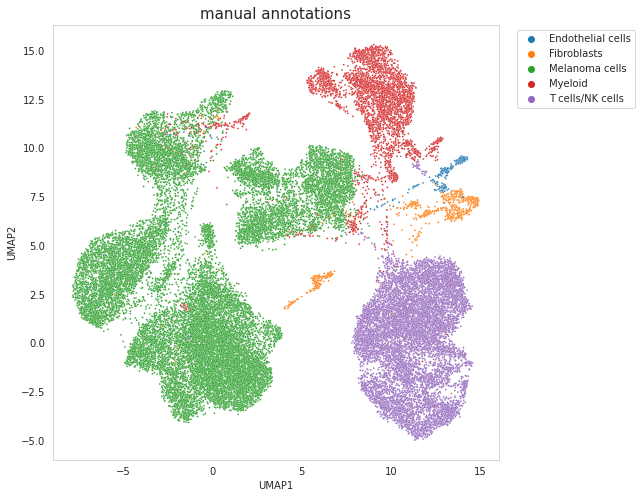

In [54]:
#plot with randomization

randomize=np.arange(len(ribas_merged.obs["orig.ident"]))
np.random.shuffle(randomize)

fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("whitegrid", {'axes.grid' : False})
scatter=sns.scatterplot(x=ribas_merged.obsm["X_umap"][:,0][randomize],y=ribas_merged.obsm["X_umap"][:,1][randomize], hue=ribas_merged.obs["manual_annotations"][randomize],s=3)
scatter.legend(bbox_to_anchor= (1.03, 1) );
scatter.set_xlabel("UMAP1", fontsize = 10)
scatter.set_ylabel("UMAP2", fontsize = 10)
scatter.set_title("manual annotations", fontsize = 15)
plt.savefig("figures/2a_2.pdf",format='pdf',bbox_inches='tight')

In [25]:
#make nice labels for treatment timepoints

treatment=[]
for i in ribas_merged.obs["orig.ident"]:
    if "_pre_" in i:
        treatment.append("pre")
    elif "on" in i:
        if "later" not in i:
            treatment.append("on")
        else:
            treatment.append("on_later")
    

ribas_merged.obs["treatment"]=treatment

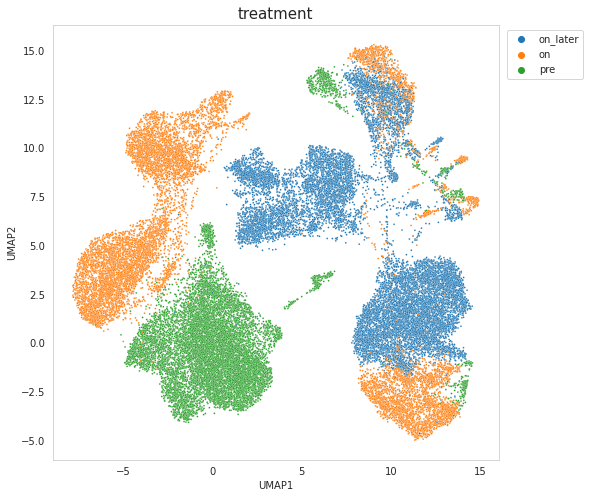

In [55]:
randomize=np.arange(len(ribas_merged.obs["orig.ident"]))
np.random.shuffle(randomize)
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("whitegrid", {'axes.grid' : False})
scatter=sns.scatterplot(x=ribas_merged.obsm["X_umap"][:,0][randomize],y=ribas_merged.obsm["X_umap"][:,1][randomize], hue=ribas_merged.obs["treatment"][randomize],s=3)
scatter.legend(bbox_to_anchor= (1.2, 1) );
scatter.set_xlabel("UMAP1", fontsize = 10)
scatter.set_ylabel("UMAP2", fontsize = 10)
scatter.set_title("treatment", fontsize = 15)
plt.savefig("figures/2a_1.pdf",format='pdf',bbox_inches='tight')